# Librerías

In [3]:
import os
import sys

import numpy as np
import pandas as pd 
import random
from glob import glob
import re
from scipy import interp  
from itertools import cycle


import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
%matplotlib inline
import cv2


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.datasets import make_classification  

import tensorflow as tf

from keras.utils import layer_utils, np_utils
from keras.preprocessing.image import ImageDataGenerator  
from keras.applications import densenet, vgg16  
from keras.models import Sequential, Model, load_model  
from keras.layers import Conv2D, MaxPooling2D  
from keras.layers import Activation, Dropout, Flatten, Dense  
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback  
from keras import regularizers  
from keras import backend as K 

import pickle

Using TensorFlow backend.


# Importar imágenes

## Funciones

In [4]:
def open_images_names(directory):
    
    """
    **************************************************************
    
    Abre las imagenes de un directorio y las almacena en un array.
    Extrae el nombre del artista del path de la imagen.
    
    Input:
    *directory. Path en el que se encuentran las imágenes.
    Output:
    *np.array con la información de las imágenes
    *np.array con el nombre del artista.
    
    ***************************************************************
    """
    
    images_all = []
    images = glob(directory)
    i_ = 0
    
    for img in images:
        im = cv2.imread(img)
        images_all.append(np.asarray(im))
        i_ += 1
    
    artists = []
    for artist in images:
        art = re.sub("_", " ", (",").join(re.findall("\w+_", artist))[:-1])
        artists.append(art)

        
    return images_all, artists

In [15]:
def muestra (bd): 
    
    """
    **************************************************************
    
    Muestra de forma aleatoria una de las imágenes importadas junto
    con información de su tamaño y autor.
    
    ***************************************************************
    """
    
    plt.rcParams['figure.figsize'] = (8, 15) 
    
    num = random.randrange(len(images))
    print(f'Autor: {artists[num]}')
    print(f'Dimensión:{bd[num].shape}')
    print(f'Filas: {bd[num].shape[0]}')
    print(f'Columnas: {bd[num].shape[1]}')
    print(f'Profundidad: {bd[num].shape[2]}')

    plt.imshow(cv2.cvtColor(bd[num], cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

## Proceso

Aplicando la función <code>open_images_names</code> obtendremos las imágenes a analizar junto con una lista con los nombres que se extraen del archivo, lo unico que tenemos que pasarle a la función es la dirección del directorio donde están nuestras imagenes junto con <k>/**</k> para que nos extraiga todos los archivos que hay dentro.

In [6]:
images, artists = open_images_names("images/**")

Echaremos un primer vistazo a la estructura que tiene nuestros inputs.

In [7]:
print(f'Disponemos de un total de {len(images)} imagenes con {len(pd.unique(artists))} artistas diferentes, entre los que encontramos a {pd.unique(artists)[random.randrange(len(pd.unique(artists)))]}, {pd.unique(artists)[random.randrange(len(pd.unique(artists)))]} o {pd.unique(artists)[random.randrange(len(pd.unique(artists)))]}.')

Disponemos de un total de 8683 imagenes con 50 artistas diferentes, entre los que encontramos a Caravaggio, Paul Klee o Salvador Dali.


Con la función <code>muestra</code> podemos ver imágenes de nuestra colección junto con el nombre del artista y el tamaño. Cada vez que se ejecute saldrá una diferente.

Autor: Hieronymus Bosch
Dimensión:(764, 301, 3)
Filas: 764
Columnas: 301
Profundidad: 3


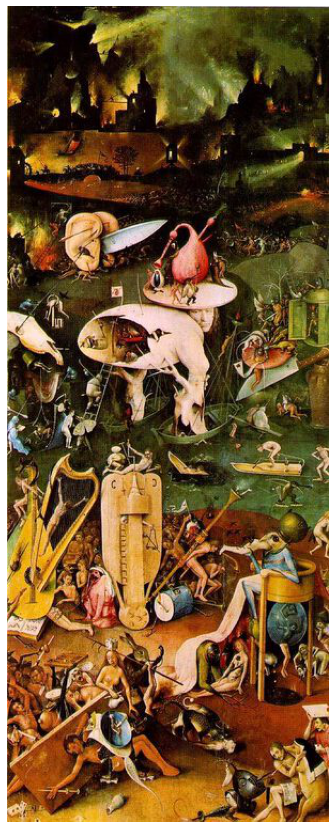

In [45]:
muestra(images)

Deberemos aplicar <code>LabelEncoder</code> para convertir nuestra variable dependiente categórica en números para que nuestro modelo lo pueda comprender mejor.

In [9]:
le = LabelEncoder()
le_artists = le.fit_transform(artists)

Crearemos un diccionario para poder decodificar más adelante.

In [10]:
artists_dict = {}
for i in range(0, len(le_artists)):
    artists_dict[le_artists[i]]= artists[i]

In [32]:
class_names = pd.unique(artists)

# Ajustar el tamaño de las imágenes

## Funciones

In [34]:
def resize_data(data):  
    
    """
    **************************************************************
    
    Ajusta el tamaño de la imágen para su estandarización.
    
    ***************************************************************
    """
    
        
    res_data = []
    for i in range(len(data)):
        res = cv2.resize(data[i], dim, interpolation=cv2.INTER_LINEAR)
        res_data.append(res)

    return res_data

In [63]:
def compara_muestras(db1, db2):
        
    """
    **************************************************************
    
    Muestra de forma aleatoria una de las imágenes importadas junto
    con información de su tamaño y autor.
    
    ***************************************************************
    """
    
    plt.rcParams['figure.figsize'] = (15, 8) 
    
    num = random.randrange(len(db1))
    
    print(f'Autor: {artists[num]}')
    print(f'Dimensión original:{db1[num].shape}')
    print(f'Dimensión ajustada:{db2[num].shape}')
    print(f'Filas originales: {db1[num].shape[0]}')
    print(f'Filas ajustadas: {db2[num].shape[0]}')
    print(f'Columnas originales: {db1[num].shape[1]}')
    print(f'Columnas ajustadas: {db2[num].shape[1]}')
    print(f'Profundidad: {db1[num].shape[2]}')
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('Imagen original vs imagen ajustada')

    ax1.imshow(cv2.cvtColor(db1[num], cv2.COLOR_BGR2RGB))
    ax1.axis('off')
    ax1.set_title("Imagen original")
    ax2.imshow(cv2.cvtColor(db2[num], cv2.COLOR_BGR2RGB))
    ax2.axis('off')
    ax2.set_title("Imagen ajustada")
    plt.show()

## Proceso

Las imágenes que forman nuestra clección tienen diferentes tamaños, deberemos establecer un tamaño común para todas para poder entrenar nuestro algoritmo.

In [ ]:
dim = (225, 225)

In [54]:
images_resized = resize_data(images)

Comparamos la imagen original con el ajuste.

Autor: Edgar Degas
Dimensión original:(968, 1214, 3)
Dimensión ajustada:(225, 225, 3)
Filas originales: 968
Filas ajustadas: 225
Columnas originales: 1214
Columnas ajustadas: 225
Profundidad: 3


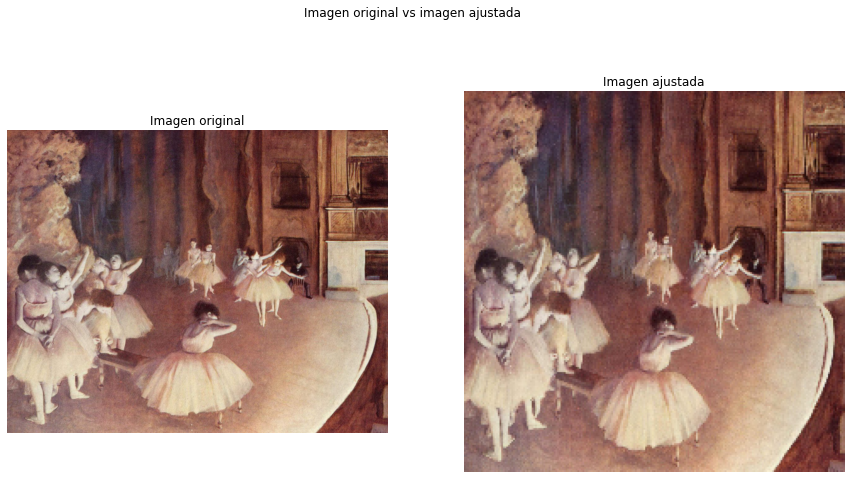

In [82]:
compara_muestras(images, images_resized)

# DataAumentation

In [76]:
df = pd.DataFrame(images, columns = ['images'])

In [77]:
df['artist'] = artists
df['artist_code'] = le_artists

In [78]:
df.head()

,images,artist,artist_code
0,"[[[87, 99, 101], [43, 55, 57], [33, 42, 45], [...",Pieter Bruegel,40
1,"[[[84, 136, 149], [88, 140, 153], [87, 139, 15...",Francisco Goya,16
2,"[[[68, 80, 92], [63, 75, 87], [58, 70, 82], [5...",Paul Cezanne,35
3,"[[[122, 156, 186], [120, 154, 184], [109, 143,...",Vincent van Gogh,48
4,"[[[5, 6, 4], [0, 0, 0], [0, 2, 1], [0, 1, 0], ...",Titian,46


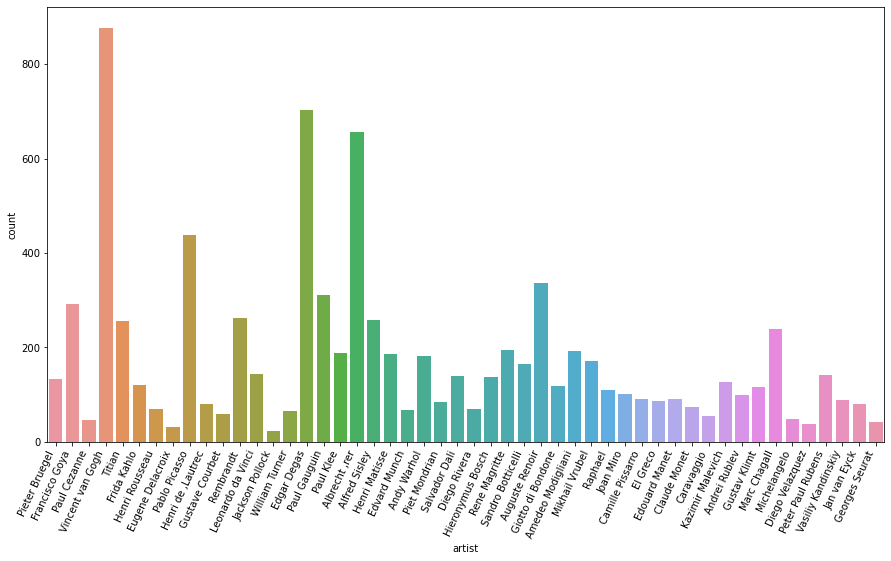

In [81]:
artists_plot = sns.countplot(df['artist'])
_ = artists_plot.set_xticklabels(artists_plot.get_xticklabels(), rotation=65, horizontalalignment='right')

# Separar train/test

In [33]:
x_train_original, x_test_original, y_train_original, y_test_original = train_test_split(images_resized, le_artists, test_size=0.2, random_state=42)

In [34]:
num_classes = len(class_names)

In [35]:
y_train = np_utils.to_categorical(y_train_original, num_classes)
y_test = np_utils.to_categorical(y_test_original, num_classes)

In [107]:
dsize = (48, 48)
input_shape = (48, 48, 3)
steps_per_epoch = len(x_train_resized) / 32

In [40]:
x_train_resized = resize_data(x_train_original)  
x_test_resized = resize_data(x_test_original)  
x_train_resized = x_train_resized / 255  
x_test_resized = x_test_resized / 255  

# ImageDataGenerator

In [108]:
img_width, img_height = 224, 224  
nb_train_samples = len(x_train_original)
nb_validation_samples = len(x_test_original)
epochs = 10  
batch_size = 32  
n_classes = num_classes

In [41]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

In [ ]:
datagen.fit(x_train_resized)

In [54]:
K.set_image_data_format('channels_last')  

In [55]:
K.set_learning_phase(1) 

# Simple NN

In [57]:
def create_simple_nn():  
    model = Sequential()
    model.add(Flatten(input_shape=(48, 48, 3), name="Input_layer"))
    model.add(Dense(1000, activation='relu', name="Hidden_layer_1"))
    model.add(Dense(500, activation='relu', name="Hidden_layer_2"))
    model.add(Dense(50, activation='softmax', name="Output_layer"))

    return model

In [58]:
snn_model = create_simple_nn()  
snn_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc', 'mse'])

In [59]:
snn_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_layer (Flatten)        (None, 6912)              0         
_________________________________________________________________
Hidden_layer_1 (Dense)       (None, 1000)              6913000   
_________________________________________________________________
Hidden_layer_2 (Dense)       (None, 500)               500500    
_________________________________________________________________
Output_layer (Dense)         (None, 50)                25050     
Total params: 7,438,550
Trainable params: 7,438,550
Non-trainable params: 0
_________________________________________________________________


In [150]:
snn = snn_model.fit(datagen.flow(x_train_resized, y_train, batch_size=batch_size),
          steps_per_epoch=steps_per_epoch, epochs=epochs, validation_data=(x_test_resized, y_test))  

Epoch 1/10
218/217 [==============================] - 27s 122ms/step - loss: 2.6579 - acc: 0.2951 - mse: 0.0169 - val_loss: 3.6159 - val_acc: 0.0547 - val_mse: 0.0193
Epoch 2/10
218/217 [==============================] - 26s 119ms/step - loss: 2.6353 - acc: 0.2933 - mse: 0.0169 - val_loss: 3.6658 - val_acc: 0.0380 - val_mse: 0.0195
Epoch 3/10
218/217 [==============================] - 26s 118ms/step - loss: 2.6068 - acc: 0.3068 - mse: 0.0167 - val_loss: 3.6482 - val_acc: 0.0432 - val_mse: 0.0194
Epoch 4/10
218/217 [==============================] - 27s 122ms/step - loss: 2.5965 - acc: 0.3061 - mse: 0.0168 - val_loss: 3.6044 - val_acc: 0.0864 - val_mse: 0.0193
Epoch 5/10
218/217 [==============================] - 26s 121ms/step - loss: 2.5788 - acc: 0.2953 - mse: 0.0167 - val_loss: 3.5972 - val_acc: 0.0766 - val_mse: 0.0192
Epoch 6/10
218/217 [==============================] - 28s 127ms/step - loss: 2.5734 - acc: 0.3072 - mse: 0.0166 - val_loss: 3.6295 - val_acc: 0.0771 - val_mse: 0.019

In [67]:
evaluation = snn_model.evaluate(x=x_test_resized, y=y_test, batch_size=32, verbose=1)  
evaluation

1737/1737 [==============================] - 2s 942us/step


[3.539750405955603, 0.13356362283229828, 0.019039146602153778]

In [136]:
def plot_train_vs_test (model):
    
    plt.rcParams['figure.figsize'] = (8, 6) 
    
    plt.figure(0)  
    plt.plot(model.history['acc'],'r')  
    plt.plot(model.history['val_acc'],'g')  
    plt.xticks(np.arange(0, 11, 2.0))   
    plt.xlabel("Num of Epochs")  
    plt.ylabel("Accuracy")  
    plt.title("Training Accuracy vs Validation Accuracy")  
    plt.legend(['train','validation'])

    plt.figure(1)  
    plt.plot(model.history['loss'],'r')  
    plt.plot(model.history['val_loss'],'g')  
    plt.xticks(np.arange(0, 11, 2.0))   
    plt.xlabel("Num of Epochs")  
    plt.ylabel("Loss")  
    plt.title("Training Loss vs Validation Loss")  
    plt.legend(['train','validation'])

    plt.show()  

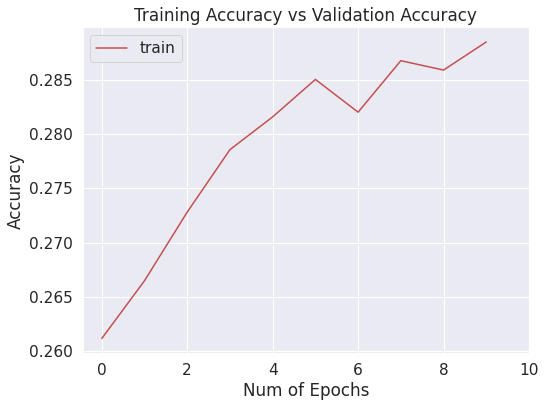

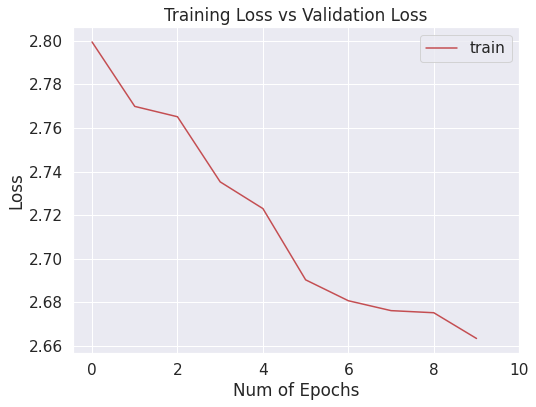

In [132]:
plot_train_vs_test(snn)

In [74]:
snn_pred = snn_model.predict(x_test_resized, batch_size=32, verbose=1)  
snn_predicted = np.argmax(snn_pred, axis=1) 

1737/1737 [==============================] - 1s 720us/step


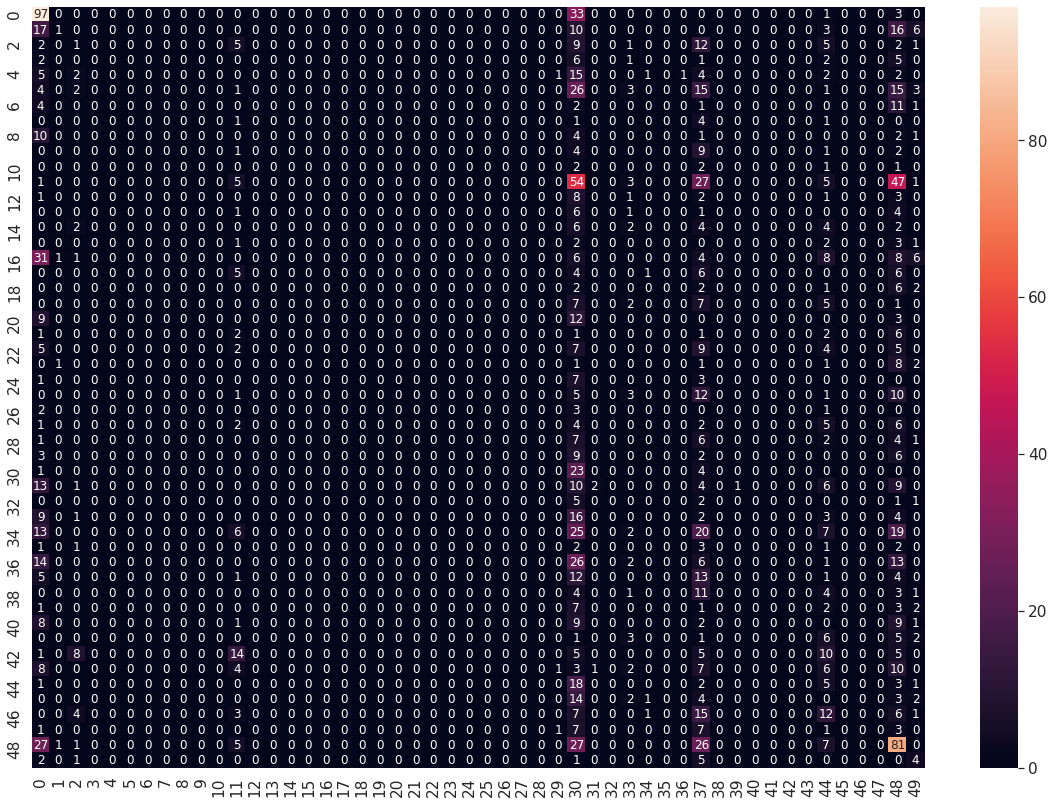

In [79]:
#Creamos la matriz de confusión
snn_cm = confusion_matrix(np.argmax(y_test, axis=1), snn_predicted)

# Visualizamos la matriz de confusión
snn_df_cm = pd.DataFrame(snn_cm, range(50), range(50))  
plt.figure(figsize = (20,14))  
sns.set(font_scale=1.4) #for label size  
sns.heatmap(snn_df_cm, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [82]:
snn_report = classification_report(np.argmax(y_test, axis=1), snn_predicted)  
print(snn_report)

              precision    recall  f1-score   support

           0       0.32      0.72      0.44       134
           1       0.25      0.02      0.04        53
           2       0.04      0.03      0.03        38
           3       0.00      0.00      0.00        17
           4       0.00      0.00      0.00        33
           5       0.00      0.00      0.00        70
           6       0.00      0.00      0.00        19
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        18
           9       0.00      0.00      0.00        17
          10       0.00      0.00      0.00         6
          11       0.08      0.03      0.05       143
          12       0.00      0.00      0.00        16
          13       0.00      0.00      0.00        13
          14       0.00      0.00      0.00        20
          15       0.00      0.00      0.00         9
          16       0.00      0.00      0.00        65
          17       0.00    

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [144]:
def plot_roc(model_pred):

    # Plot linewidth.
    lw = 2

    # Compute ROC curve and ROC area for each class
    fpr = dict()  
    tpr = dict()  
    roc_auc = dict()  
    for i in range(n_classes):  
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], model_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), model_pred.ravel())  
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)  
    for i in range(n_classes):  
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr  
    tpr["macro"] = mean_tpr  
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(1)  
    plt.plot(fpr["micro"], tpr["micro"],  
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],  
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])  
    for i, color in zip(range(n_classes-97), colors):  
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)  
    plt.xlim([0.0, 1.0])  
    plt.ylim([0.0, 1.05])  
    plt.xlabel('False Positive Rate')  
    plt.ylabel('True Positive Rate')  
    plt.title('Some extension of Receiver operating characteristic to multi-class')  
    plt.legend(loc="lower right")  
    plt.show()


    # Zoom in view of the upper left corner.
    plt.figure(2)  
    plt.xlim(0, 0.2)  
    plt.ylim(0.8, 1)  
    plt.plot(fpr["micro"], tpr["micro"],  
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],  
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])  
    for i, color in zip(range(3), colors):  
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)  
    plt.xlabel('False Positive Rate')  
    plt.ylabel('True Positive Rate')  
    plt.title('Some extension of Receiver operating characteristic to multi-class')  
    plt.legend(loc="lower right")  
    plt.show()  

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


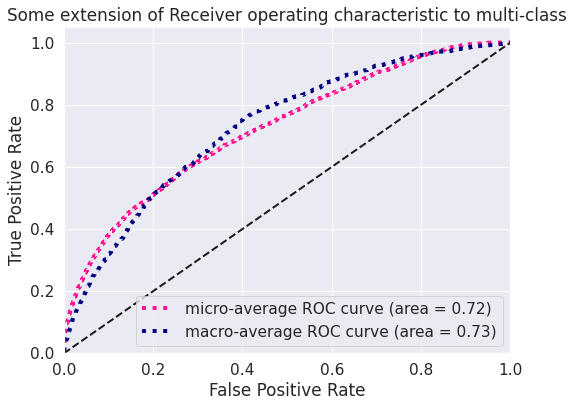

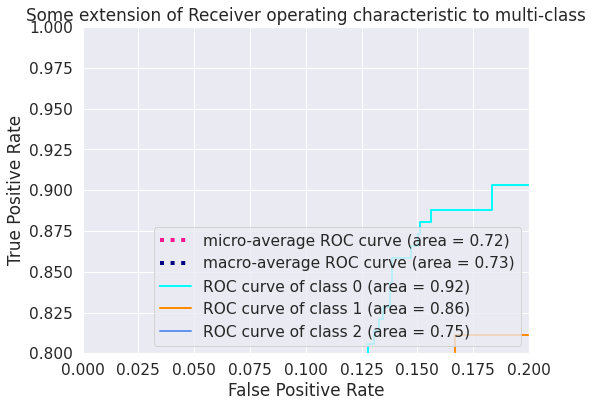

In [145]:
plot_roc(snn_pred)

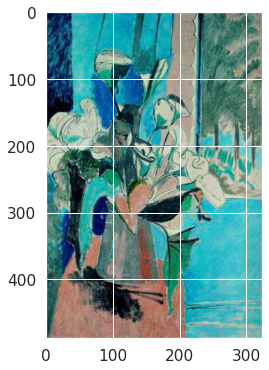

class for image 1: 36
predicted:         30


In [84]:
imgplot = plt.imshow(x_train_original[0])  
plt.show()  
print('class for image 1: ' + str(np.argmax(y_test[0])))  
print('predicted:         ' + str(snn_predicted[0]))  

In [86]:
#Histórico
with open('simplenn_history.txt', 'wb') as file_pi:  
  pickle.dump(snn.history, file_pi)

# Convultional Nets

In [103]:
def create_simple_cnn():  
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), input_shape=(48, 48, 3), activation='relu'))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))

    model.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(1024, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(50, activation='softmax'))

    return model

In [104]:
scnn_model = create_simple_cnn()  
scnn_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc', 'mse']) 

In [105]:
scnn_model.summary() 

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 46, 46, 32)        896       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 44, 44, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 20, 20, 128)       73856     
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 18, 18, 256)       295168    
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 16, 16, 512)       1180160   
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 8, 8, 512)        

In [109]:
scnn = scnn_model.fit(datagen.flow(x_train_resized, y_train, batch_size=batch_size),
                      epochs=epochs, verbose=1, steps_per_epoch=steps_per_epoch,
                      validation_data=(x_test_resized, y_test), shuffle=True)

Epoch 1/10
218/217 [==============================] - 240s 1s/step - loss: 3.6294 - acc: 0.1159 - mse: 0.0192 - val_loss: 3.6826 - val_acc: 0.0783 - val_mse: 0.0193
Epoch 2/10
218/217 [==============================] - 241s 1s/step - loss: 3.4664 - acc: 0.1533 - mse: 0.0189 - val_loss: 3.6216 - val_acc: 0.1353 - val_mse: 0.0192
Epoch 3/10
218/217 [==============================] - 242s 1s/step - loss: 3.3961 - acc: 0.1660 - mse: 0.0188 - val_loss: 3.5809 - val_acc: 0.1531 - val_mse: 0.0192
Epoch 4/10
218/217 [==============================] - 241s 1s/step - loss: 3.2597 - acc: 0.1880 - mse: 0.0185 - val_loss: 3.5858 - val_acc: 0.1503 - val_mse: 0.0192
Epoch 6/10
218/217 [==============================] - 244s 1s/step - loss: 3.2159 - acc: 0.1949 - mse: 0.0183 - val_loss: 3.5813 - val_acc: 0.1353 - val_mse: 0.0191
Epoch 7/10
218/217 [==============================] - 239s 1s/step - loss: 3.1795 - acc: 0.2004 - mse: 0.0183 - val_loss: 3.6023 - val_acc: 0.1203 - val_mse: 0.0192
Epoch 8/10

In [112]:
cnn_evaluation = scnn_model.evaluate(x=x_test_resized, y=y_test, batch_size=32, verbose=1)  
cnn_evaluation  

1737/1737 [==============================] - 17s 10ms/step


[3.719799489074558, 0.09096142649650574, 0.019508572295308113]

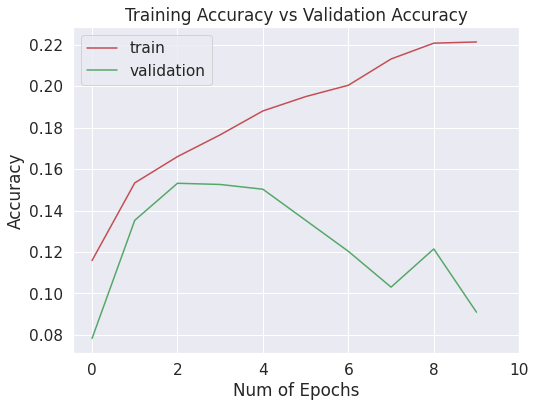

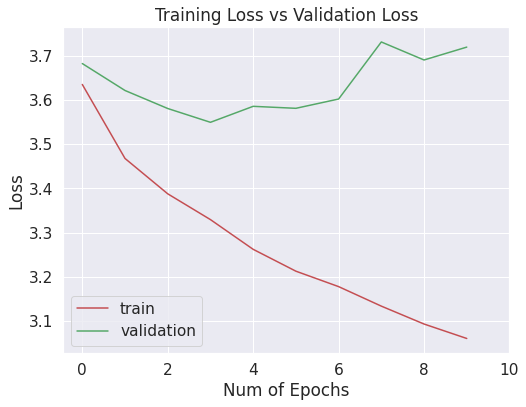

In [137]:
plot_train_vs_test(scnn)

In [139]:
scnn_pred = scnn_model.predict(x_test_resized, batch_size=32, verbose=1)  
scnn_predicted = np.argmax(scnn_pred, axis=1)

1737/1737 [==============================] - 18s 11ms/step


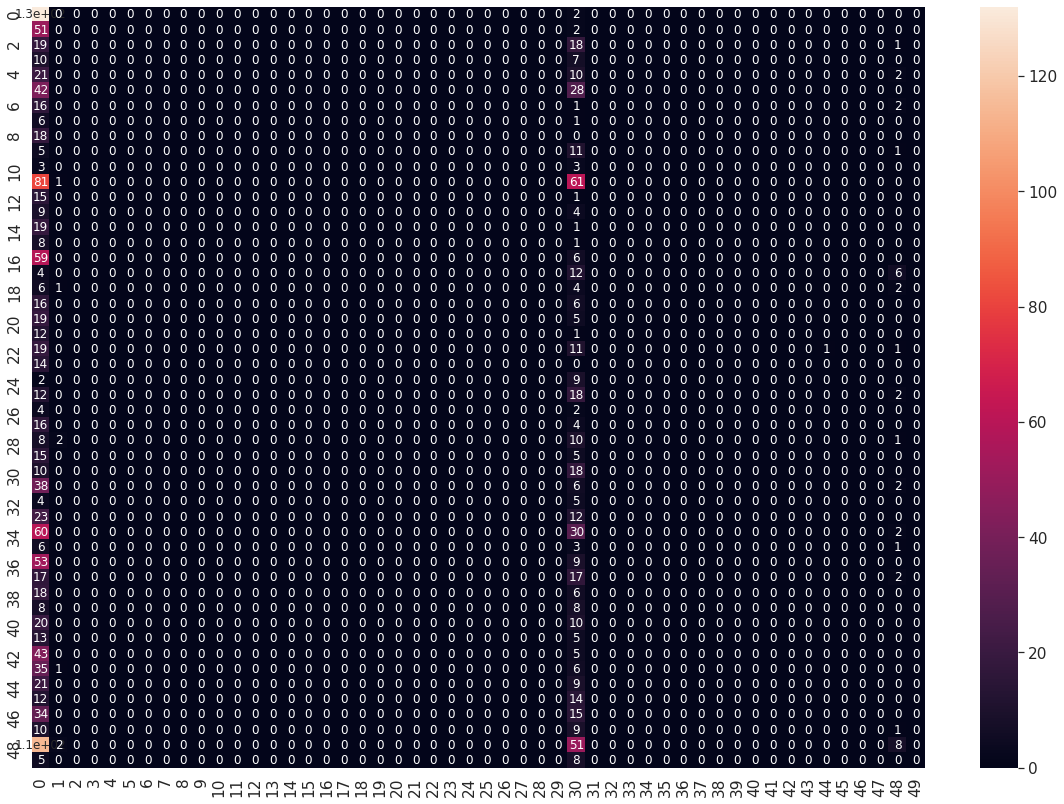

In [142]:
#Creamos la matriz de confusión
scnn_cm = confusion_matrix(np.argmax(y_test, axis=1), scnn_predicted)

# Visualiamos la matriz de confusión
scnn_df_cm = pd.DataFrame(scnn_cm, range(50), range(50))  
plt.figure(figsize = (20,14))  
sns.set(font_scale=1.4) #for label size  
sns.heatmap(scnn_df_cm, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [143]:
scnn_report = classification_report(np.argmax(y_test, axis=1), scnn_predicted)  
print(scnn_report) 

              precision    recall  f1-score   support

           0       0.11      0.99      0.20       134
           1       0.00      0.00      0.00        53
           2       0.00      0.00      0.00        38
           3       0.00      0.00      0.00        17
           4       0.00      0.00      0.00        33
           5       0.00      0.00      0.00        70
           6       0.00      0.00      0.00        19
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        18
           9       0.00      0.00      0.00        17
          10       0.00      0.00      0.00         6
          11       0.00      0.00      0.00       143
          12       0.00      0.00      0.00        16
          13       0.00      0.00      0.00        13
          14       0.00      0.00      0.00        20
          15       0.00      0.00      0.00         9
          16       0.00      0.00      0.00        65
          17       0.00    

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


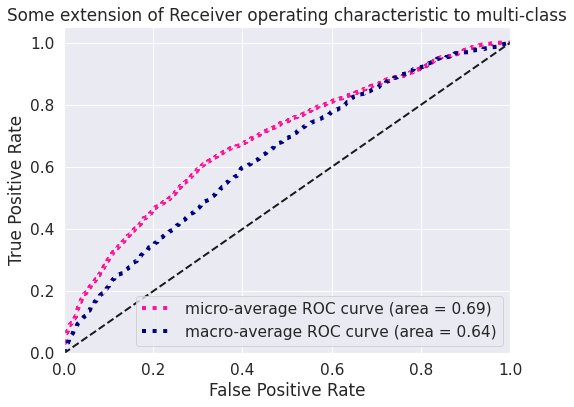

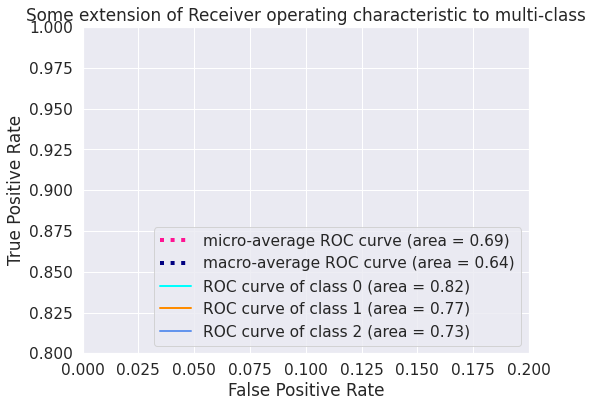

In [146]:
plot_roc(scnn_pred)

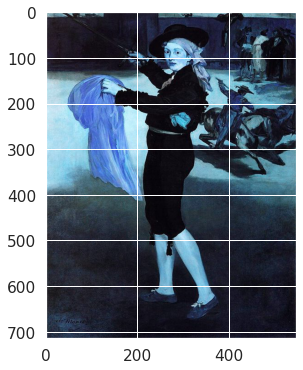

class for image 1: 30
predicted:         0


In [148]:
imgplot = plt.imshow(x_train_original[5])  
plt.show()  
print('class for image 1: ' + str(np.argmax(y_test[5])))  
print('predicted:         ' + str(scnn_predicted[5])) 

In [149]:
#Histórico
with open('scnn_history.txt', 'wb') as file_pi:  
  pickle.dump(scnn.history, file_pi)

# VGG-16 (hay una 19 y una bis)

In [ ]:
def create_vgg16():  
  model = vgg16.VGG16(include_top=True, weights=None, input_tensor=None, input_shape=input_shape, pooling=None, classes=len(pd.unique(artists)))

  return model

In [ ]:
vgg16_model = create_vgg16()  
vgg16_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc', 'mse']) 

In [72]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0     

In [73]:
vgg16 = vgg16_model.fit(datagen.flow(x_train_resized, y_train, batch_size=batch_size),
                      epochs=epochs, verbose=1, steps_per_epoch=len(x_train_resized) / 32,
                      validation_data=(x_test_resized, y_test), shuffle=True) 

Train on 6946 samples, validate on 1737 samples
Epoch 1/10
6946/6946 [==============================] - 269s 39ms/step - loss: 3.8697 - acc: 0.1006 - mse: 0.0196 - val_loss: 3.8239 - val_acc: 0.1007 - val_mse: 0.0195
Epoch 2/10
6946/6946 [==============================] - 264s 38ms/step - loss: 3.7748 - acc: 0.1011 - mse: 0.0195 - val_loss: 3.7093 - val_acc: 0.1007 - val_mse: 0.0194
Epoch 3/10
6946/6946 [==============================] - 269s 39ms/step - loss: 3.6330 - acc: 0.1011 - mse: 0.0193 - val_loss: 3.5724 - val_acc: 0.1007 - val_mse: 0.0192
Epoch 4/10
6946/6946 [==============================] - 268s 39ms/step - loss: 3.5694 - acc: 0.1057 - mse: 0.0192 - val_loss: 3.5618 - val_acc: 0.1007 - val_mse: 0.0192
Epoch 5/10
6946/6946 [==============================] - 273s 39ms/step - loss: 3.5578 - acc: 0.1110 - mse: 0.0192 - val_loss: 3.5518 - val_acc: 0.0789 - val_mse: 0.0191
Epoch 6/10
6946/6946 [==============================] - 272s 39ms/step - loss: 3.5357 - acc: 0.1211 - mse: 

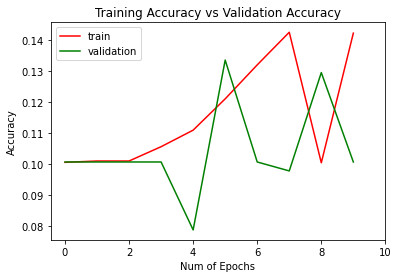

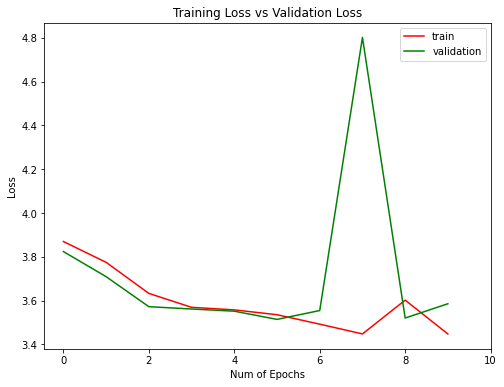

In [74]:
plt.figure(0)  
plt.plot(vgg16.history['acc'],'r')  
plt.plot(vgg16.history['val_acc'],'g')  
plt.xticks(np.arange(0, 11, 2.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Accuracy")  
plt.title("Training Accuracy vs Validation Accuracy")  
plt.legend(['train','validation'])

plt.figure(1)  
plt.plot(vgg16.history['loss'],'r')  
plt.plot(vgg16.history['val_loss'],'g')  
plt.xticks(np.arange(0, 11, 2.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Training Loss vs Validation Loss")  
plt.legend(['train','validation'])

plt.show()  

In [75]:
vgg16_pred = vgg16_model.predict(x_test_resized, batch_size=32, verbose=1)  
vgg16_predicted = np.argmax(vgg16_pred, axis=1)  

1737/1737 [==============================] - 18s 11ms/step


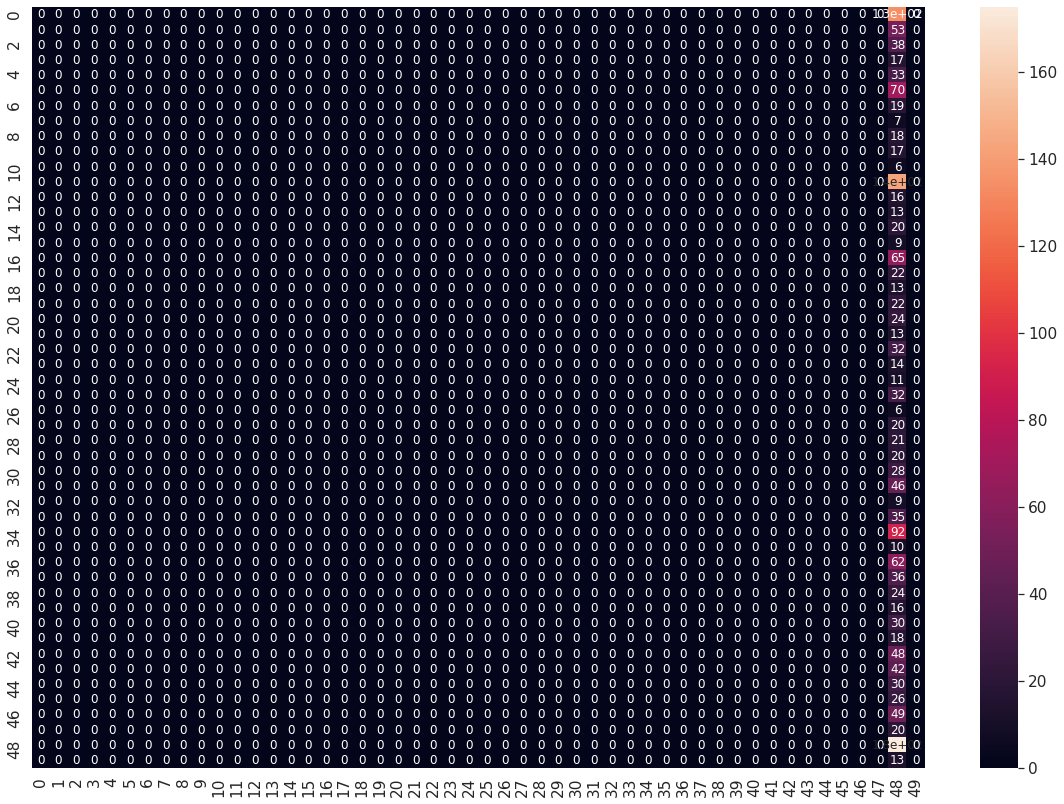

In [80]:
#Creamos la matriz de confusión
vgg16_cm = confusion_matrix(np.argmax(y_test, axis=1), vgg16_predicted)

# Visualiamos la matriz de confusión
vgg16_df_cm = pd.DataFrame(vgg16_cm, range(50), range(50))  
plt.figure(figsize = (20,14))  
sns.set(font_scale=1.4) #for label size  
sns.heatmap(vgg16_df_cm, annot=True, annot_kws={"size": 12}) # font size  
plt.show()

In [83]:
vgg16_report = classification_report(np.argmax(y_test, axis=1), vgg16_predicted)  
print(vgg16_report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       134
           1       0.00      0.00      0.00        53
           2       0.00      0.00      0.00        38
           3       0.00      0.00      0.00        17
           4       0.00      0.00      0.00        33
           5       0.00      0.00      0.00        70
           6       0.00      0.00      0.00        19
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        18
           9       0.00      0.00      0.00        17
          10       0.00      0.00      0.00         6
          11       0.00      0.00      0.00       143
          12       0.00      0.00      0.00        16
          13       0.00      0.00      0.00        13
          14       0.00      0.00      0.00        20
          15       0.00      0.00      0.00         9
          16       0.00      0.00      0.00        65
          17       0.00    

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


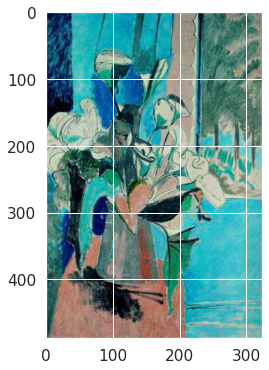

class for image 1: 36
predicted:         48


In [86]:
imgplot = plt.imshow(x_train_original[0])  
plt.show()  
print('class for image 1: ' + str(np.argmax(y_test[0])))  
print('predicted:         ' + str(vgg16_predicted[0]))  

In [92]:
#Histórico
with open('vgg16_history.txt', 'wb') as file_pi:  
    pickle.dump(vgg16.history, file_pi)

# ResNet

# DenseNet121

In [ ]:
def build_model():  
    base_model = densenet.DenseNet121(input_shape=(img_width, img_height, 3),
                                     include_top=False,
                                     pooling='avg')

    x = base_model.output
    x = Dense(1000, kernel_regularizer=regularizers.l1_l2(0.01), activity_regularizer=regularizers.l2(0.01))(x)
    x = Activation('relu')(x)
    x = Dense(500, kernel_regularizer=regularizers.l1_l2(0.01), activity_regularizer=regularizers.l2(0.01))(x)
    x = Activation('relu')(x)
    predictions = Dense(n_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    return model


In [ ]:
model = build_model()  
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', 'mse'])  

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=8, verbose=1, min_delta=1e-4)  
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, min_delta=1e-4)  
callbacks_list = [early_stop, reduce_lr] 

In [ ]:
model_history = model.fit_generator(  
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks=callbacks_list)

# NASNet

# Comparativa

In [ ]:
with open(path_base + '/simplenn_history.txt', 'rb') as f:  
  snn_history = pickle.load(f)

In [ ]:
with open(path_base + '/scnn_history.txt', 'wb') as file_pi:  
  pickle.dump(scnn.history, file_pi)

In [ ]:
with open(path_base + '/vgg16_history.txt', 'rb') as f:  
  vgg16_history = pickle.load(f)

In [ ]:
plt.figure(0)  
plt.plot(snn_history['val_acc'],'r')  
plt.plot(scnn_history['val_acc'],'g')  
plt.plot(vgg16_history['val_acc'],'b')  
plt.plot(vgg19.history['val_acc'],'y')  
plt.xticks(np.arange(0, 11, 2.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Accuracy")  
plt.title("Simple NN Accuracy vs simple CNN Accuracy")  
plt.legend(['simple NN','CNN','VGG 16'])  

In [ ]:
plt.figure(0)  
plt.plot(snn_history['val_loss'],'r')  
plt.plot(scnn.history['val_loss'],'g')  
plt.xticks(np.arange(0, 11, 2.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Simple NN Loss vs simple CNN Loss")  
plt.legend(['simple NN','CNN', 'VGG 16'])

In [ ]:
plt.figure(0)  
plt.plot(snn_history['val_mean_squared_error'],'r')  
plt.plot(scnn.history['val_mean_squared_error'],'g')  
plt.xticks(np.arange(0, 11, 2.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Mean Squared Error")  
plt.title("Simple NN MSE vs simple CNN MSE")  
plt.legend(['simple NN','CNN', 'VGG 16'])  